# Quantifying Uncertainty
This notebook serves as the supporting material for Chapter 13 **Quantifying Uncertainty**. In this notebook we will show how to use the code repository to tame unceratinty with degrees of belief. In this notebook we will concentrate on the task of representing and computing with probabilistic information in general. First, let's load the aima-jar.

In [17]:
%classpath add jar ../out/artifacts/aima_core_jar/aima-core.jar

## Basic Probability Notion
For our agent to represent and use probabilistic information, we need a formal language. Appendix A(from text) includes a standard introduction to
elementary probability theory. Here, we take an approach more suited to the needs of AI and
more consistent with the concepts of formal logic.

In probability
theory, the set of all possible worlds is called the **sample space**. The possible worlds are
mutually exclusive and exhaustive—two possible worlds cannot both be the case, and one
possible world must be the case. For example, if we are about to roll two (distinguishable)
dice, there are $36$ possible worlds to consider: $(1,1), (1,2), . . ., (6,6)$. The Greek letter $\Omega$
(uppercase omega) is used to refer to the sample space, and $\omega$ (lowercase omega) refers to
elements of the space, that is, particular possible worlds.

A fully specified **probability model** associates a numerical probability $P (\omega)$ with each
possible world.The basic axioms of probability theory say that every possible world has a
probability between 0 and 1 and that the total probability of the set of possible worlds is 1

$0 \leq P (\omega) \leq 1$ for every $\omega$ and $\displaystyle\sum_{\omega \in \Omega}P (\omega) = 1$

For example, if we assume that each die is fair and the rolls don’t interfere with each other,
then each of the possible worlds (1,1), (1,2), . . ., (6,6) has probability $frac{1}{36}$. On the other
hand, if the dice conspire to produce the same number, then the worlds (1,1), (2,2), (3,3), etc.,
might have higher probabilities, leaving the others with lower probabilities.

Probabilistic assertions and queries are not usually about particular possible worlds, but
about sets of them.In AI,
the sets are always described by propositions in a formal language.Propositions describing sets of possible worlds are written in a notation that combines elements of propositional logic and constraint satisfaction notation.The probability associated with a proposition is defined to be the sum of the probabilities of the worlds in which it holds

For any proposition, $\phi, P(\phi) = \displaystyle\sum_{\omega in \phi} P(\omega)$.

The code repository already contains a variety of propositions in the [proposition module](https://github.com/aimacode/aima-java/tree/AIMA3e/aima-core/src/main/java/aima/core/probability/proposition). However, to implement a custom proposition, we can always extend the Proposition interface which is as follows :

````java

public interface Proposition {
	/**
	 * 
	 * @return the Set of RandomVariables in the World (sample space) that this
	 *         Proposition is applicable to.
	 */
	Set<RandomVariable> getScope();

	/**
	 * 
	 * @return the Set of RandomVariables from this propositions scope that are
	 *         not constrained to any particular set of values (e.g. bound =
	 *         P(Total = 11), while unbound = P(Total)). If a variable is
	 *         unbound it implies the distributions associated with the variable
	 *         is being sought.
	 */
	Set<RandomVariable> getUnboundScope();

	/**
	 * Determine whether or not the proposition holds in a particular possible
	 * world.
	 * 
	 * @param possibleWorld
	 *            A possible world is defined to be an assignment of values to
	 *            all of the random variables under consideration.
	 * @return true if the proposition holds in the given possible world, false
	 *         otherwise.
	 */
	boolean holds(Map<RandomVariable, Object> possibleWorld);
}
````

Variables in probability theory are called **random variables** and their names begin with
an uppercase letter. Every random variable has a domain. For eg, in the random event of throwing two dice simultaneously, let $Total$ represent the sum of the numbers on the dice and let $Die_1$ represent the number on the first die. Thus, in the dice example, Total and Die 1 are random variables. The domain of
Total for two dice is the set {2, . . . , 12} and the domain of Die 1 is {1, . . . , 6}. The code repository already contains a lot of implemented domains and random variables, but let us create our own custom random variable and a custom domain for the dice example above
We will first implement a domain for the dice example using AbstractFiniteDomain class which is an extra layer on our Domain interface.



In [18]:
package aima.notebooks.quantifyinguncertainty;

import aima.core.probability.domain.*;
import java.util.*;

class TotalDiceDomain extends AbstractFiniteDomain{
    
    Set<Integer> values = new HashSet<>();
    
    public TotalDiceDomain(){
        for(int i =2;i<=12;i++){
            values.add(i);
        }
    }
    
    
    @Override
    public int size(){
        return values.size();
    }
    
    @Override
    public boolean isOrdered(){
        return true;
    }
    
    @Override
    public Set<Integer> getPossibleValues(){
        return values;
    }
}

aima.notebooks.quantifyinguncertainty.TotalDiceDomain

In [19]:
package aima.notebooks.quantifyinguncertainty;

import aima.core.probability.domain.*;
import aima.core.probability.*;
import java.util.*;

class TotalDiceRandomVar implements RandomVariable {
    String name;
    Domain domain;
    
    public TotalDiceRandomVar(String name, Domain domain){
        this.name = name;
        this.domain = domain;
    }
    
    @Override
    public Domain getDomain(){
        return this.domain;
    }
    
    @Override
    public String getName(){
        return this.name;
    }
    
} 


aima.notebooks.quantifyinguncertainty.TotalDiceRandomVar

In [20]:
package aima.notebooks.quantifyinguncertainty;
import aima.core.probability.domain.*;
import aima.core.probability.*;

TotalDiceDomain totalDomain = new TotalDiceDomain();
RandomVariable totalDiceRandomVar = new TotalDiceRandomVar("Total",totalDomain);
System.out.println("Name = "+ totalDiceRandomVar.getName());
System.out.println("Domain = " + totalDomain.getPossibleValues().toString());

Name = Total
Domain = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


null

The above implementations can also be carried out using existing APIs from the code repository, Foe instance, the totalDiceDomain and the totalDiceRandomVar can be easily implemented as follows.

In [21]:
package aima.notebooks.quantifyinguncertainty;

import aima.core.probability.domain.*;
import aima.core.probability.*;
import aima.core.probability.util.*;

FiniteIntegerDomain totalDiceDomain = new FiniteIntegerDomain(2,3,4,5,6,7,8,9,10,11,12);
RandVar totalRandomVariable = new RandVar("Total", totalDiceDomain);

System.out.println(totalRandomVariable);
System.out.println(totalRandomVariable.getDomain());


Total
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


null

Let us look how to create a Probability Model. To create a ProbabilityModel, we have to implement the ProbabilityModel interface from the code. The following is the ProbabilityModelInterface :

````java
public interface ProbabilityModel {
	/**
	 * The default threshold for rounding errors. Example, to test if
	 * probabilities sum to 1:<br>
	 * <br>
	 * Math.abs(1 - probabilitySum) <
	 * ProbabilityModel.DEFAULT_ROUNDING_THRESHOLD;
	 */
	final double DEFAULT_ROUNDING_THRESHOLD = 1e-8;

	/**
	 * 
	 * @return true, if 0 <= P(&omega;) <= 1 for every &omega; and
	 *         &sum;<sub>&omega; &isin; &Omega;</sub> P(&omega;) = 1 (Equation
	 *         13.1 pg. 484 AIMA3e), false otherwise.
	 */
	boolean isValid();

	/**
	 * For any proposition &phi;, P(&phi;) = &sum;<sub>&omega; &isin;
	 * &phi;</sub> P(&omega;). Refer to equation 13.2 page 485 of AIMA3e.
	 * Probabilities such as P(Total = 11) and P(doubles) are called
	 * unconditional or prior probabilities (and sometimes just "priors" for
	 * short); they refer to degrees of belief in propositions in the absence of
	 * any other information.
	 * 
	 * @param phi
	 *            the propositional terms for which a probability value is to be
	 *            returned.
	 * @return the probability of the proposition &phi;.
	 */
	double prior(Proposition... phi);

	/**
	 * Unlike unconditional or prior probabilities, most of the time we have
	 * some information, usually called evidence, that has already been
	 * revealed. This is the conditional or posterior probability (or just
	 * "posterior" for short). Mathematically speaking, conditional
	 * probabilities are defined in terms of unconditional probabilities as
	 * follows, for any propositions a and b, we have:<br>
	 * <br>
	 * P(a | b) = P(a AND b)/P(b)<br>
	 * <br>
	 * which holds whenever P(b) > 0. Refer to equation 13.3 page 485 of AIMA3e.
	 * This can be rewritten in a different form called the <b>product rule</b>: <br>
	 * <br>
	 * P(a AND b) = P(a | b)P(b)<br>
	 * <br>
	 * and also as:<br>
	 * <br>
	 * P(a AND b) = P(b | a)P(a)<br>
	 * <br>
	 * whereby, equating the two right-hand sides and dividing by P(a) gives you
	 * Bayes' rule:<br>
	 * <br>
	 * P(b | a) = (P(a | b)P(b))/P(a) - i.e. (likelihood * prior)/evidence
	 * 
	 * @param phi
	 *            the proposition for which a probability value is to be
	 *            returned.
	 * @param evidence
	 *            information we already have.
	 * @return the probability of the proposition &phi; given evidence.
	 */
	double posterior(Proposition phi, Proposition... evidence);

	/**
	 * @return a consistent ordered Set (e.g. LinkedHashSet) of the random
	 *         variables describing the atomic variable/value pairs this
	 *         probability model can take on. Refer to pg. 486 AIMA3e.
	 */
	Set<RandomVariable> getRepresentation();
````

Sometimes we will want to talk about the probabilities of all the possible values of a random
variable. We could write:

P (Weather = sunny) = 0.6

P (Weather = rain) = 0.1

P (Weather = cloudy) = 0.29

P (Weather = snow ) = 0.01

but as an abbreviation we will allow

**P**(Weather ) = $\langle 0.6, 0.1, 0.29, 0.01 \rangle $

where the bold **P** indicates that the result is a vector of numbers, and where we assume a pre-
defined ordering $\langle$sunny, rain, cloudy , snow $\rangle$ on the domain of Weather . We say that the
P statement defines a probability distribution for the random variable Weather. In addition to distributions on single variables, we need notation for distributions on
multiple variables. Commas are used for this. For example, **P**(Weather , Cavity) denotes
the probabilities of all combinations of the values of Weather and Cavity. This is a 4 × 2
table of probabilities called the joint probability distribution of Weather and Cavity. We can use the `ProbabilityTable` class from the code repository to create joint distributions. Let's see how we can encode the joint probability distribution of the following table :

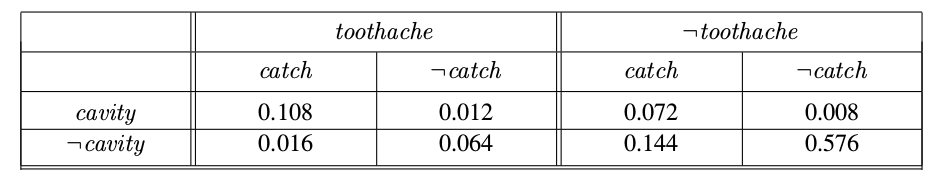

In [22]:
package aima.notebooks.quantifyinguncertainty;

import aima.core.probability.domain.*;
import aima.core.probability.*;
import aima.core.probability.util.*;
import aima.core.probability.proposition.*;

// First we define the random variables
RandVar cavityRv = new RandVar("Cavity", new BooleanDomain());
RandVar toothacheRv = new RandVar("Toothache", new BooleanDomain());
RandVar catchRv = new RandVar("Catch", new BooleanDomain());


ProbabilityTable jointDistribution = new ProbabilityTable(
            new double[] {
				// Toothache = true, Cavity = true, Catch = true
				0.108,
				// Toothache = true, Cavity = true, Catch = false
				0.012,
				// Toothache = true, Cavity = false, Catch = true
				0.016,
				// Toothache = true, Cavity = false, Catch = false
				0.064,
				// Toothache = false, Cavity = true, Catch = true
				0.072,
				// Toothache = false, Cavity = true, Catch = false
				0.008,
				// Toothache = false, Cavity = false, Catch = true
				0.144,
				// Toothache = false, Cavity = false, Catch = false
				0.576 },
                    toothacheRv,cavityRv,catchRv);

// The values are assigned as follows :
// First the last random variable is assigned all the possible values and then the second last and so on.
System.out.println("Joint Distribution = "+jointDistribution.toString());

// We can then ask about any subset of the jointDistribution
// Lets ask about the probability of having a toothache and cavity but not of catch
// We will use the AssignmentProposition class for assigning the values to the random variables.
AssignmentProposition toothache = new AssignmentProposition(toothacheRv,true);
AssignmentProposition cavity = new AssignmentProposition(cavityRv,true);
AssignmentProposition catchVal = new AssignmentProposition(catchRv,false);
System.out.println("Probability of having cavity and toothache but not of catch = " +
                   jointDistribution.getValue(toothache,cavity,catchVal));

Joint Distribution = <0.108, 0.012, 0.016, 0.064, 0.072, 0.008, 0.144, 0.576>
Probability of having cavity and toothache but not of catch = 0.012


null

From the preceding definition of possible worlds, it follows that a probability model is
completely determined by the joint distribution for all of the random variables—the so-called
**full joint probability distribution**. For example, if the variables are Cavity, Toothache ,
and Weather , then the full joint distribution is given by P(Cavity, Toothache , Weather ).
This joint distribution can be represented as a 2 × 2 × 4 table with 16 entries. the above example represents the full joint distribution of a similar case. To encode a probability model using a full joint distribiution we can use the `FullJointDistributionModel` class from the code repo as follows :

In [23]:
package aima.notebooks.quantifyinguncertainty;

import aima.core.probability.domain.*;
import aima.core.probability.*;
import aima.core.probability.util.*;
import aima.core.probability.proposition.*;
import aima.core.probability.full.*;

// First we define the random variables
RandVar cavityRv = new RandVar("Cavity", new BooleanDomain());
RandVar toothacheRv = new RandVar("Toothache", new BooleanDomain());
RandVar catchRv = new RandVar("Catch", new BooleanDomain());


// Create the full joint distribution from the table given above.
FullJointDistributionModel model = new FullJointDistributionModel(
                            new double[] {
				// Toothache = true, Cavity = true, Catch = true
				0.108,
				// Toothache = true, Cavity = true, Catch = false
				0.012,
				// Toothache = true, Cavity = false, Catch = true
				0.016,
				// Toothache = true, Cavity = false, Catch = false
				0.064,
				// Toothache = false, Cavity = true, Catch = true
				0.072,
				// Toothache = false, Cavity = true, Catch = false
				0.008,
				// Toothache = false, Cavity = false, Catch = true
				0.144,
				// Toothache = false, Cavity = false, Catch = false
				0.576 },
                    toothacheRv,cavityRv,catchRv);
// Let's define a few assignments
AssignmentProposition toothache = new AssignmentProposition(toothacheRv,true);
AssignmentProposition cavity = new AssignmentProposition(cavityRv,true);
// Now let's have a look at what we can do with the model.
// To print the random variables in the model
System.out.println("The random variables in the model = " + model.getRepresentation());
// We can calculate the prior probabilities of a variety of combinations of random variables
System.out.println("The prior probability of having a toothache = "+ model.prior(toothache));
System.out.println("The prior probability of having a cavity = "+ model.prior(cavity));
System.out.println("The probability of having a cavity and toothache simultaneously is = "+ model.prior(toothache, cavity));
// We can also calculate a variety of posterior probabilities from the model as follows
System.out.println("The probability of having a toothache given that the person has a cavity(causal direction) is = "+ 
                  model.posterior(toothache,cavity));
System.out.println("The probability of having a cavity given that the person is experiencing toothache(diagnostic direction) is = "
                  + model.posterior(cavity,toothache));


The random variables in the model = [Toothache, Cavity, Catch]
The prior probability of having a toothache = 0.2
The prior probability of having a cavity = 0.2
The probability of having a cavity and toothache simultaneously is = 0.12
The probability of having a toothache given that the person has a cavity(causal direction) is = 0.6
The probability of having a cavity given that the person is experiencing toothache(diagnostic direction) is = 0.6


null

## Inference using full joint distributions

The basic ideas of inference using full joint distributions have been covered in the previous cell. However, let's visit those ideas iteratively once again. **Probabilistic inference** can be defined as the computation of posterior probabilities for query propositions given observed evidence. We use the
full joint distribution as the “knowledge base” from which answers to all questions may be de-
rived.

We will reuse the previous example: a domain consisting of just the three Boolean variables
Toothache , Cavity, and Catch (the dentist’s nasty steel probe catches in my tooth). The full
joint distribution is a 2 × 2 × 2 the table above.
One particularly common task is to extract the distribution over some subset of variables or
a single variable. For example, adding the entries in the first row gives the unconditional or
**marginal probability** of cavity:

P (cavity) = 0.108 + 0.012 + 0.072 + 0.008 = 0.2

This process is called marginalization, or summing out—because we sum up the probabil-
ities for each possible value of the other variables, thereby taking them out of the equation.

In most cases, we are interested in computing conditional probabilities of some vari-
ables, given evidence about others. Conditional probabilities can be found by first using the definition of conditional probability to obtain an expression in terms of unconditional probabilities and then evaluating the expression from the full joint distribution. For example, we can compute the
probability of a cavity, given evidence of a toothache, as follows:

$$P(cavity\mid toothache) = \frac{P(cavity\land toothache)}{P(toothache)}$$

From the above formula we can extract a general inference procedure. We begin with the case in which the query involves a single variable, X (Cavity in the example). Let **E** be the
list of evidence variables (just Toothache in the example), let e be the list of observed values
for them, and let Y be the remaining unobserved variables (just Catch in the example). The
query is **P**(X | e) and can be evaluated as
$$\textbf{P}(X\mid \textbf{e}) = \alpha\displaystyle\sum_{y}^{} \textbf{P}(X,\textbf{e,y}) $$

where the summation is over all possible ys (i.e., all possible combinations of values of the
unobserved variables Y). Notice that together the variables X, E, and Y constitute the com-
plete set of variables for the domain, so **P**(X, **e, y**) is simply a subset of probabilities from the
full joint distribution.

All these ideas are combined together in the `prior()` and `posterior()` functions of the `FullJointDistributionModel` class and these methods can be directly used to calculate all the prior and posterior probabilities from a full joint model.

## Bayes' Rule and its applications

The **product rule** can be written in the following two ways:

$P(a\land b) = P(a\mid b)P(b)$ and $P(a\land b) = P(b\mid a)P(a)$

On equating these two equations we arrive at the bayes rule :

$$ P(a\mid b) = \frac{P(b\mid a)P(a)}{P(b)}$$

This simple
equation underlies most modern AI systems for probabilistic inference.

The authors have explained the importance of Bayes rule in a brilliant manner in the text. Let's steal a few lines from the text to understand it's importance.

On the surface, Bayes’ rule does not seem very useful. It allows us to compute the single
term P (b | a) in terms of three terms: P (a | b), P (b), and P (a). That seems like two steps
backwards, but Bayes’ rule is useful in practice because there are many cases where we do
have good probability estimates for these three numbers and need to compute the fourth.
Often, we perceive as evidence the effect of some unknown cause and we would like to
determine that cause. In that case, Bayes’ rule becomes

$$ P(cause\mid effect) = \frac{P(effect\mid cause)P(cause)}{P(effect)}$$

The conditional probability P (effect | cause) quantifies the relationship in the **causal direction**, whereas P (cause | effect) describes the **diagnostic direction**. In a task such as medical
diagnosis, we often have conditional probabilities on causal relationships (that is, the doctor
knows P (symptoms | disease)) and want to derive a diagnosis, P (disease | symptoms). For
example, a doctor knows that the disease meningitis causes the patient to have a stiff neck,
say, 70% of the time. The doctor also knows some unconditional facts: the prior probabil-
ity that a patient has meningitis is 1/50,000, , and the prior probability that any patient has a
stiff neck is 1%. Letting s be the proposition that the patient has a stiff neck and m be the
proposition that the patient has meningitis, we can carry out the following diagnosis :
$$P(s \mid m) = 0.7 $$
$$P(m) = 1/50000 $$
$$ P(s) = 0.01 $$
$$ P(m\mid s) = \frac{P(s\mid m)P(m)}{P(s)} = \frac{0.7\times1/50000} = 0.0014 $$

That is, we expect less than 1 in 700 patients with a stiff neck to have meningitis. Notice that
even though a stiff neck is quite strongly indicated by meningitis (with probability 0.7), the
probability of meningitis in the patient remains small. This is because the prior probability of
stiff necks is much higher than that of meningitis.

The text is filled a lot of interesting and sometimes counter intuitive examples. Students are expected to go through them.

## Using Bayes Rule

We have seen that Bayes’ rule can be useful for answering probabilistic queries conditioned
on several pieces of evidence. However, the full joint probability model that we discussed is incapable of beginning the inference procedure with a given set of posterier probabilities. To work with bayes rule, we need models that can work easily with conditional probabilities and at the same time can scale up to accomodate increasing evidence.

Given a full joint distribution model of a particular system we can carry out inference using the techniques listed in this notebook and demonstrated with the use of cavity example. In the next few notebooks, we will learn a powerful way to utilise Bayes' Theorem in the form of **Bayesian Networks**.